In [1]:
import pandas as pd
import datetime
import numpy as np
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 5, 1)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-27,284.540009,279.950012,281.799988,283.170013,29271900.0,283.170013
2020-04-28,285.829987,278.200012,285.079987,278.579987,28001200.0,278.579987
2020-04-29,289.670013,283.890015,284.730011,287.730011,34320200.0,287.730011
2020-04-30,294.529999,288.350006,289.959991,293.799988,45766000.0,293.799988
2020-05-01,299.000000,285.850006,286.250000,289.070007,60095200.0,289.070007


In [2]:
mall_two = df[['Adj Close']]
mall_two

,Adj Close
Date,
2020-01-02,299.638885
2020-01-03,296.725769
2020-01-06,299.090149
2020-01-07,297.683533
2020-01-08,302.472137
...,...
2020-04-27,283.170013
2020-04-28,278.579987
2020-04-29,287.730011


In [3]:
mall_two = mall_two['Adj Close'].values
mall_two = mall_two.reshape(-1, 1)
print(mall_two.shape)
mall_two[:5]

(84, 1)


array([[299.6388855 ],
       [296.72576904],
       [299.09014893],
       [297.68353271],
       [302.47213745]])

In [4]:
dataset_train = np.array(mall_two[:int(df.shape[0]*0.8)])
dataset_test = np.array(mall_two[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(67, 1)
(67, 1)


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.73197392],
       [0.70364448],
       [0.72663757],
       [0.71295853],
       [0.75952669]])

In [6]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [7]:
x_train, y_train = create_dataset(dataset_train)
x_train[:1]

array([[0.73197392, 0.70364448, 0.72663757, 0.71295853, 0.75952669,
        0.82200625, 0.8287971 , 0.89311994, 0.85159639, 0.83859608,
        0.87643276, 0.91029234, 0.88933633, 0.90029957, 0.91514316,
        0.9062173 , 0.8154089 , 0.90020222, 0.96471886, 0.96015918,
        0.82084199, 0.81259545, 0.9114563 , 0.93668116, 0.97315949,
        0.93027315, 0.94505472, 0.92618861, 1.        , 0.97734108,
        0.97811923, 0.92025663, 0.9651851 , 0.93289873, 0.86239403,
        0.7177865 , 0.61956609, 0.66400844, 0.47797322, 0.47641721,
        0.72391316, 0.63162503, 0.7621315 , 0.66663432, 0.62880475,
        0.40649627, 0.59292027, 0.49654759, 0.23203342, 0.52124864]])

In [8]:
x_test, y_test = create_dataset(dataset_test)
x_test[:1]

array([[316.93780518, 323.572052  , 323.10317993, 308.77719116,
        307.92919922, 318.09506226, 320.68893433, 324.44000244,
        320.02999878, 321.54998779, 319.60998535, 327.20001221,
        324.86999512, 324.95001221, 319.        , 323.61999512,
        320.29998779, 313.04998779, 298.17999268, 288.07998657,
        292.6499939 , 273.51998901, 273.35998535, 298.80999756,
        289.32000732, 302.73999023, 292.92001343, 289.02999878,
        266.17001343, 285.33999634, 275.42999268, 248.22999573,
        277.97000122, 242.21000671, 252.86000061, 246.66999817,
        244.77999878, 229.24000549, 224.36999512, 246.88000488,
        245.52000427, 258.44000244, 247.74000549, 254.80999756,
        254.28999329, 240.91000366, 244.92999268, 241.41000366,
        262.47000122, 259.42999268]])

In [9]:
# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Building the model

In [10]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

Using TensorFlow backend.


In [11]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
import os
if(not os.path.exists('stock_prediction.h5')):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save('stock_prediction.h5')

In [13]:
model = load_model('stock_prediction.h5')

# Visualizing Results

In [14]:
import matplotlib.pyplot as plt

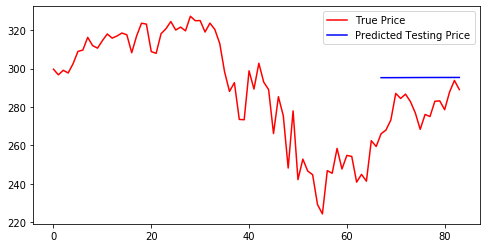

In [15]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(mall_two, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

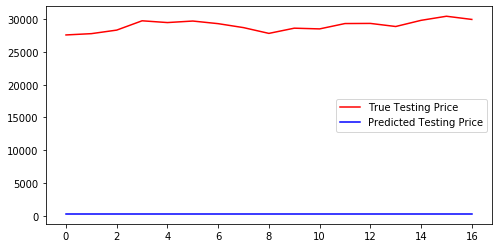

In [16]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()

In [17]:
x = x_test[-1]
num_timesteps = 100
preds = []
for i in range(num_timesteps):
    data = np.expand_dims(x, axis=0)
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    preds.append(prediction[0][0])
    x = np.delete(x, 0, axis=0) # delete first row
    x = np.vstack([x, prediction]) # add prediction

print(preds)

[295.3626, 295.36923, 295.3763, 295.38348, 295.39044, 295.39682, 295.40274, 295.4081, 295.4126, 295.4166, 295.4199, 295.4227, 295.42502, 295.4272, 295.42883, 295.43008, 295.43155, 295.43228, 295.4333, 295.43402, 295.43466, 295.43503, 295.43542, 295.43607, 295.43643, 295.43692, 295.4371, 295.43747, 295.43768, 295.4378, 295.43808, 295.4383, 295.43866, 295.4388, 295.43903, 295.43915, 295.4393, 295.43945, 295.4395, 295.43954, 295.43958, 295.43964, 295.43967, 295.4398, 295.43988, 295.43997, 295.44003, 295.44003, 295.44016, 295.4402, 295.4402, 295.4402, 295.4402, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.4402, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.44022, 295.4402, 295.44022, 295.44022